In [1]:
import numpy as np
from tqdm import tqdm
import copy

In [2]:
beta = 7
batch_size = 1024
L = 16

In [3]:
def jackknife(data):
    n = len(data)
    jackknife_samples = np.empty((n, n-1))
    
    for i in range(n):
        jackknife_samples[i] = np.delete(data, i)
    
    return jackknife_samples

def jackknife_stats(data):
    jackknife_samples = jackknife(data)
    jackknife_means = np.mean(jackknife_samples, axis=1)
    mean = np.mean(jackknife_means)
    error = np.sqrt((len(data) - 1) * np.mean((jackknife_means - mean) ** 2))
    
    return mean, error

In [4]:
def compute_autocorrelation(samples, max_lag=None):
  
    x = np.asarray(samples, dtype=float)
    N = len(x)
    if max_lag is None or max_lag >= N:
        max_lag = N - 1

    mean_x = np.mean(x)
    var_x = np.var(x)
    if np.isclose(var_x, 0.0):
        return np.ones(max_lag + 1)

    autocorr = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        x_front = x[:N - lag] - mean_x
        x_back  = x[lag:] - mean_x
        cov_k = np.sum(x_front * x_back) / N
        autocorr[lag] = cov_k / var_x
    
    return autocorr

def compute_ess(samples, max_lag=None):

    x = np.asarray(samples, dtype=float)
    N = len(x)
    autocorr = compute_autocorrelation(x, max_lag=max_lag)
    
    tau_int = 1.0
    for k in range(1, len(autocorr)):
        if autocorr[k] < 0:
            break
        tau_int += 2.0 * autocorr[k]

    ess = N / tau_int
    return ess, tau_int

In [5]:
def gauge_cooling(lattice, n_steps=1):
    for _ in range(n_steps):
        lattice = np.mod(lattice+np.pi, 2*np.pi) - np.pi
    return lattice

def metropolis_hastings_update(x, y, p, random_a):
    accept_mask = random_a < p
    updated_x = copy.deepcopy(x) 
    updated_x[accept_mask] = y[accept_mask]
    acceptance_rate = np.sum(accept_mask) / accept_mask.size  
    return updated_x, acceptance_rate

def get_action(phi):

    ph_w = np.cos(phi[:,:,:,0] - phi[:,:,:,1] + np.roll(phi[:,:,:,1], -1, 1) - np.roll(phi[:,:,:,0], -1, 2))
    return -beta*np.sum(ph_w, axis=(1,2))

def get_drift(phi):
    phi_d = np.zeros((batch_size,L,L,2))
    drift1 = beta * np.sin(phi[:,:,:,0] - phi[:,:,:,1] + np.roll(phi[:,:,:,1], -1, axis=1) - np.roll(phi[:,:,:,0], -1, axis=2))
    phi_d[:,:,:,0] = -drift1 + np.roll(drift1, 1, axis=2)
    phi_d[:,:,:,1] = drift1 - np.roll(drift1, 1, axis=1)
    return phi_d



def M_H(x,y,noise,h):
    drift = beta*h*(get_drift(x) + get_drift(y))

    p_1 = -(1/h)*0.25*np.sum((np.sqrt(2*h)*noise + drift)**2, axis=(1, 2, 3))
    p_2 = 0.5*np.sum(noise ** 2, axis=(1, 2, 3))
    delta_q = np.exp(p_1+p_2)
    S_x = get_action(x)
    S_y = get_action(y)
    
    delta_pi = np.exp(S_x-S_y)
    accept_prob = delta_pi * delta_q
    #print(accept_prob)
    random_i =  np.random.rand(batch_size)
    return metropolis_hastings_update(x,y,accept_prob,random_i)

def wilson_loop(lattice, x, y):
    U1 = np.exp(1j * lattice[x, y, 0])
    U2 = np.exp(1j * lattice[x, (y + 1) % L, 0])
    U3 = np.exp(1j * lattice[(x + 1) % L, y, 1])
    U4 = np.exp(1j * lattice[x, y, 1])
    return np.real(U1 * U3 * np.conj(U2) * np.conj(U4))

def calculate_angle(array1,xp,yp):
    var = L
    right = array1[xp % var, yp % var][0]
    up = array1[(xp + 1) % var, yp % var][1]
    down = array1[xp % var, yp % var][1]
    left = array1[xp % var, (yp + 1) % var][0]
#    angel = right + up - left - down
    return right + up - left - down


def calculate_topological_charge(array):
    top_charge = 0
    for i in range(L):
        for j in range(L):
            angle = calculate_angle(array, i, j)
            top_charge += project_angle(angle)

    return (top_charge / (2 * np.pi))



def project_angle(angle):
    return np.remainder(angle+np.pi, (2 * np.pi)) - np.pi

def topological_suspectiblity(array):
    top_charge = 0
    for i in range(L):
        for j in range(L):
            angle = calculate_angle(array, i, j)
            top_charge += project_angle(angle)

    return (top_charge / (2 * np.pi))**2

def plaq(lat):
    Wilson_loop_values=[]
    lattice_size=lat.shape[2]
    for conf in range(lat.shape[0]):
        wilson_sum = 0
        lattice = lat[conf]
        for x in range(lattice_size):
            for y in range(lattice_size):
                wilson_sum += wilson_loop(lattice, x, y)
        Wilson_loop_values.append(wilson_sum / (lattice_size ** 2))
    return Wilson_loop_values

def wilson_loopij(array, x_len, t_len):
    Wilson_loop_values=[]
    for conf in range(array.shape[0]):
        init = np.zeros((L,L))
        for x in range(x_len):
            init += np.roll(array[conf,:,:,0],-x,axis=0)
        for t in range(t_len):
            init += np.roll(np.roll(array[conf,:,:,1],-x_len,axis=0),-t,axis=1)
        for x in range(x_len):
            init -= np.roll(np.roll(array[conf,:,:,0],(-x_len,-t_len),axis=(0,1)),x+1,axis=0)   
        for t in range(t_len):
            init -= np.roll(np.roll(array[conf,:,:,1],-t_len,axis=1),t+1,axis=1)
        wil_l = np.mean(np.cos(init),axis=(0,1))
        Wilson_loop_values.append(wil_l)
    return Wilson_loop_values

In [6]:

size =100

    
init_x = np.random.randn(batch_size,  L, L,2)  * np.pi
MH_step = 1e-5
rate = 0
x = init_x
rate_traj = []
Q_list = []
for i in tqdm(range(100)):
    MH_step = 1e-9
    rate = 0
    step_size =  5*0.81**i
    for _ in range(size):
      score_t = get_drift(x)
      mean_x = x + score_t * step_size
      randn_noise = np.random.randn(batch_size,  L, L,2)
      x_temp = mean_x + np.sqrt(2*step_size) * randn_noise
      if i>90:
        size = 1000
        x, acc_rate = M_H(x,x_temp,randn_noise,step_size)
        MH_step = MH_step+1
        rate += acc_rate
        Q_list.append(calculate_topological_charge(x[0]))
      else:
        x = x_temp
      
      x = gauge_cooling(x)
    rate_traj.append(rate/MH_step)



100%|██████████| 100/100 [10:55<00:00,  6.55s/it]


In [7]:
np.shape(Q_list)

(8100,)

In [8]:
import matplotlib.pyplot as plt

 tau_int = 5001.00


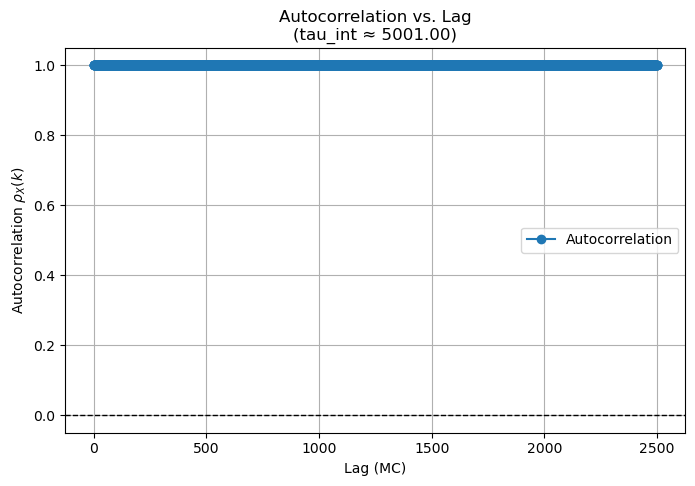

In [9]:
max_lag = 2500
autocorr = compute_autocorrelation(Q_list, max_lag=max_lag)


_, tau_int = compute_ess(Q_list, max_lag=max_lag)
print(f" tau_int = {tau_int:.2f}")

plt.figure(figsize=(8, 5))
lags = np.arange(len(autocorr))
plt.plot(lags, autocorr, marker='o', linestyle='-', label='Autocorrelation')
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)

plt.title(f"Autocorrelation vs. Lag\n(tau_int ≈ {tau_int:.2f})")
plt.xlabel("Lag (MC)")
plt.ylabel(r"Autocorrelation $\rho_X(k)$")
plt.legend(loc='best')
plt.grid(True)
plt.show()


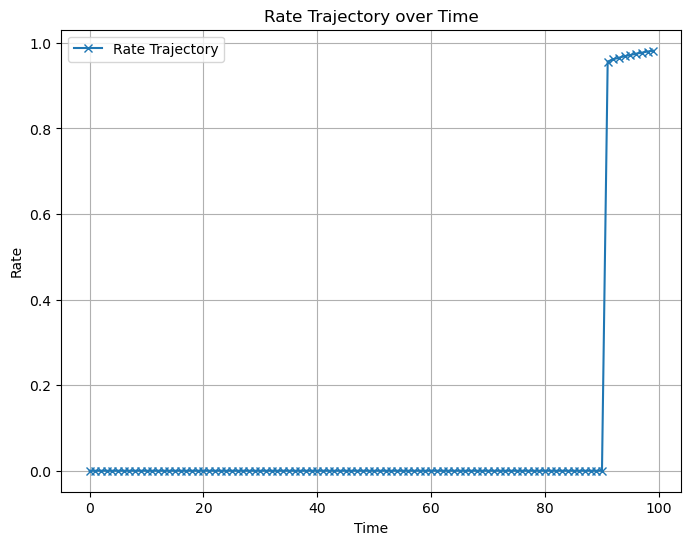

In [10]:


time = range(len(rate_traj))  

plt.figure(figsize=(8, 6))
plt.plot(time, rate_traj, marker='x', linestyle='-', label='Rate Trajectory')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Rate Trajectory over Time')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
rate/MH_step

0.9816455078115184

In [12]:
for i in range(1,7):
    print(np.mean(wilson_loopij(x[:1024],i,i)))

0.9231223575245571
0.7221334939062264
0.46638942047376364
0.23935179962015088
0.09353340279311201
0.025372324000845776


In [13]:
np.std(wilson_loopij(x[:1024],1,1))

0.0070794659534154005

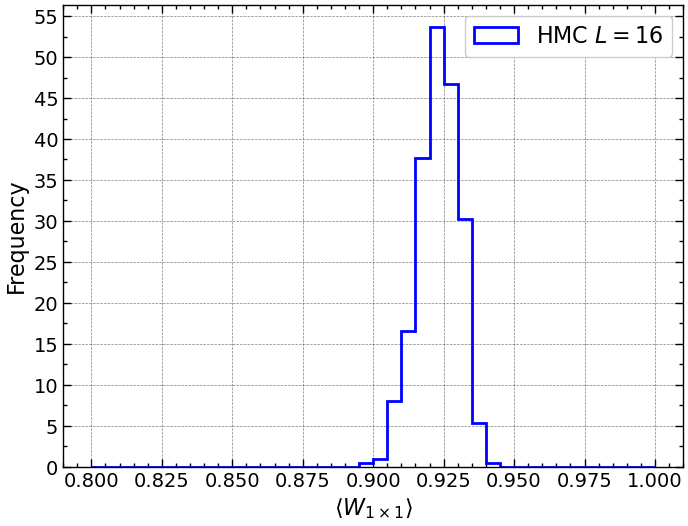

In [14]:
import scienceplots
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook','grid'])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['ytick.labelsize'] = 14 

plt.figure(figsize=(8, 6))



Xrange=(0.8,1)
plt.hist(wilson_loopij(x[:1024],1,1), bins=40,range=Xrange, histtype='step',linewidth=2,edgecolor='blue',color='blue',alpha=1,density=True,label=r'HMC $L = 16$')
#plt.title('Wilson loop')
ax = plt.gca()  
ax.yaxis.set_major_locator(MultipleLocator(5))  
ax.yaxis.set_minor_locator(MultipleLocator(2.5)) 


plt.legend()
#plt.ylim()
plt.xlabel(r'$\langle W_{1 \times 1} \rangle$', fontsize=16)
plt.ylabel(r'Frequency', fontsize=16)


plt.show()

In [15]:
top_charge_history=[]
for conf in range(x.shape[0]):
    top_charge_history.append(calculate_topological_charge(x[conf]))

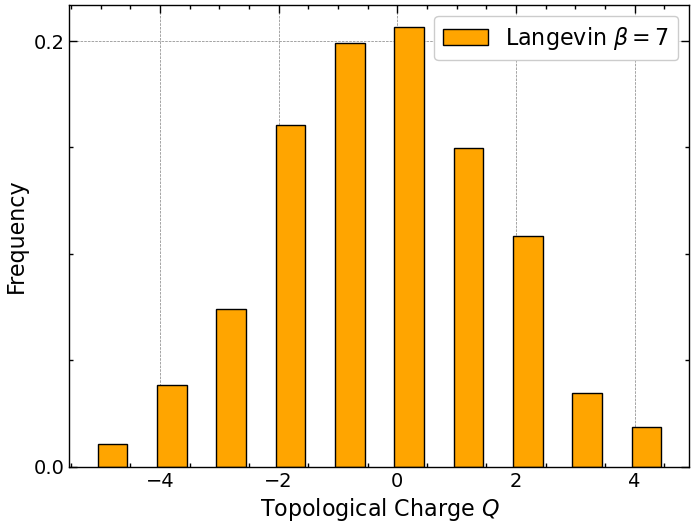

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

# 全局参数固定字体大小、dpi 等
plt.style.use(['science', 'notebook','grid'])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['ytick.labelsize'] = 14 

fig_width = 8 
fig_height = 6  

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=100)

bin_range = range(-5, 6)

hist, bins = np.histogram(top_charge_history, bins=bin_range, density=True)


ax.bar(bins[:-1] + 0.2, hist, width=0.5, edgecolor='black', color='orange', alpha=1, label=r'Langevin $\beta=7$')


ax.set_xlabel(r'Topological Charge $Q$', fontsize=16)
ax.set_ylabel(r'Frequency', fontsize=16)


plt.legend()


ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.2))  
ax.yaxis.set_minor_locator(MultipleLocator(0.05))  

plt.show()


In [17]:
suspect1 = []
for conf in range(x.shape[0]):
    suspect1.append(topological_suspectiblity(x[conf]))

In [18]:
mean, err = jackknife_stats(suspect1)
print(mean/L**2,err/L**2)

0.013526916503906252 0.0005832548539957425
